# Tratamento dos dados

In [1]:
# Importando as bibliotecas para realizar a conexão com o banco, leitura e operações com o dataframe e exibição de gráficos.
import pandas as pd
import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import para utilizar variáveis de ambiente do arquivo .env
from dotenv import load_dotenv
import os

load_dotenv('.env')

True

In [2]:
# Esse comando permite visualizar o dataframe de forma que todas as colunas e linhas fiquem visíveis.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Passando os parâmetros necessários para a conexão com o banco de dados.
connection = mysql.connector.connect(host=os.getenv('servidor'),
                                     user=os.getenv('usuario'),
                                     password=os.getenv('senha'),
                                     database='projeto-financas')

# Dentro da variável, inseri o comando de texto que realiza a consulta no banco os dados da tabela que utilizarei na análise.
# Deixei fora da consulta algumas colunas como a de nome, valor da cotação e valor em dólar que não utilizarei na análise.
# A coluna 'final_cartao' retorna os 4 números finais do cartão utilizado na compra. Na minha fatura, esses números representam
# meu cartão físico e virtual, então dentro da própria query no SQL eu criei uma coluna 'tipo_cartao' e fiz a conversão dos 
#dados para preencher essa nova coluna.
query = """SELECT data_compra,
categoria,
descricao,
parcela,
valor_reais,
CASE
	WHEN final_cartao = '1342' THEN 'Cartão Virtual'
	WHEN final_cartao = '8114' THEN 'Cartão Físico'
	ELSE final_cartao
END AS tipo_cartao

FROM gastos_cartao"""



In [4]:
# Com esse comando, realizo a consulta no banco e insiro o resultado da consulta em uma tabela dentro do dataframe 'df_gastos'.
cursor = connection.cursor()
cursor.execute(query)

resultados = cursor.fetchall()

cursor.close()
connection.close()

df_gastos = pd.DataFrame(resultados, columns=cursor.column_names)

In [5]:
# A tabela possui 185 linhas e 6 colunas.
df_gastos.shape

(185, 6)

In [6]:
df_gastos.head()

,data_compra,categoria,descricao,parcela,valor_reais,tipo_cartao
0,10/05/2023,Serviços pessoais,HNA O BOTICARIO,9/10,13.18,Cartão Virtual
1,01/10/2023,Serviços pessoais,HNA *O BOTICARIO,5/7,20.52,Cartão Virtual
2,15/12/2023,Departamento / Desconto,ZATTINI,2/4,64.97,Cartão Virtual
3,15/12/2023,Departamento / Desconto,ZATTINI,2/2,83.24,Cartão Virtual
4,15/12/2023,Departamento / Desconto,MLP *ZATTINI,2/10,87.43,Cartão Virtual


In [7]:
df_gastos.tail()

,data_compra,categoria,descricao,parcela,valor_reais,tipo_cartao
180,02/09/2023,Vestuário / Roupas,PAG DAHORASKTSHOP,1/4,25.00,Cartão Físico
181,02/09/2023,Departamento / Desconto,PAG ELLENBRIONELIGERO,Única,95.00,Cartão Físico
182,07/09/2023,Departamento / Desconto,LOJAS MEL,Única,15.98,Cartão Físico
183,12/09/2023,Transporte,AUTOPASS S.A*DESCRIPTI,Única,6.80,Cartão Físico
184,12/09/2023,Supermercados / Mercearia / Padarias / Lojas d...,COMERCIAL MARUKAI LTDA,Única,20.20,Cartão Físico


In [8]:
# Exceto a coluna 'valor_reais' que é decimal, todas as outras colunas da tabela são do tipo texto.
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data_compra  185 non-null    object 
 1   categoria    185 non-null    object 
 2   descricao    185 non-null    object 
 3   parcela      185 non-null    object 
 4   valor_reais  185 non-null    float64
 5   tipo_cartao  185 non-null    object 
dtypes: float64(1), object(5)
memory usage: 8.8+ KB


In [9]:
# Usando o describe() consigo ter uma visão de alguns valores descritivos da coluna de valor em reais. Temos a quantidade de
# valores, a média, o desvio padrão, valores mínimo e máximo, e os quartis.
# Olhando essa descrição, da pra notar que o valor mínimo é um valor negativo. Isso acontece porque a minha fatura traz descrito
# quando eu realizo o pagamento e entra como um valor negativo em relação aos gastos.
df_gastos.describe()

,valor_reais
count,185.000000
mean,5.451892
std,302.798195
min,-2326.540000
25%,13.980000
50%,29.950000
75%,56.320000
max,1080.000000


In [10]:
# Para a minha análise, quero observar somente os valores dos gastos, então atualizei a tabela somente com os valores positivos.
df_gastos = df_gastos[df_gastos['valor_reais'] >= 0]

In [11]:
# É possível identificar que a tabela já atualizou.
df_gastos.describe()

,valor_reais
count,178.000000
mean,54.651404
std,106.775326
min,2.000000
25%,14.982500
50%,30.250000
75%,59.257500
max,1080.000000


In [12]:
# O valor total gasto (últimos 6 meses)
df_gastos['valor_reais'].sum()

9727.95

In [13]:
# Na coluna de parcelas, a informação 'Única' quer dizer que eu fiz a compra à vista. Aqui apenas substituí pelo número 1 para
# dizer que é somente uma parcela.
df_gastos['parcela'].replace('Única', '1', inplace=True)

In [14]:
df_gastos.tail()

,data_compra,categoria,descricao,parcela,valor_reais,tipo_cartao
180,02/09/2023,Vestuário / Roupas,PAG DAHORASKTSHOP,1/4,25.00,Cartão Físico
181,02/09/2023,Departamento / Desconto,PAG ELLENBRIONELIGERO,1,95.00,Cartão Físico
182,07/09/2023,Departamento / Desconto,LOJAS MEL,1,15.98,Cartão Físico
183,12/09/2023,Transporte,AUTOPASS S.A*DESCRIPTI,1,6.80,Cartão Físico
184,12/09/2023,Supermercados / Mercearia / Padarias / Lojas d...,COMERCIAL MARUKAI LTDA,1,20.20,Cartão Físico


In [15]:
# Já as compras que eu parcelei aparecem na coluna no formato (parcela atual/total de parcelas). Para facilitar a análise, 
# eu separei essa informação em duas colunas utilizando a função str.split, onde o valor à esqueda da barra eu incluí na coluna
# 'parcela atual' e o valor à direita da barra eu incluí na coluna 'total_parcela'.
df_gastos['parcela_atual'] = df_gastos['parcela'].str.split('/').str[0]
df_gastos['total_parcela'] = df_gastos['parcela'].str.split('/').str[1]

In [16]:
df_gastos.tail()

,data_compra,categoria,descricao,parcela,valor_reais,tipo_cartao,parcela_atual,total_parcela
180,02/09/2023,Vestuário / Roupas,PAG DAHORASKTSHOP,1/4,25.00,Cartão Físico,1,4
181,02/09/2023,Departamento / Desconto,PAG ELLENBRIONELIGERO,1,95.00,Cartão Físico,1,NaN
182,07/09/2023,Departamento / Desconto,LOJAS MEL,1,15.98,Cartão Físico,1,NaN
183,12/09/2023,Transporte,AUTOPASS S.A*DESCRIPTI,1,6.80,Cartão Físico,1,NaN
184,12/09/2023,Supermercados / Mercearia / Padarias / Lojas d...,COMERCIAL MARUKAI LTDA,1,20.20,Cartão Físico,1,NaN


In [17]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 184
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data_compra    178 non-null    object 
 1   categoria      178 non-null    object 
 2   descricao      178 non-null    object 
 3   parcela        178 non-null    object 
 4   valor_reais    178 non-null    float64
 5   tipo_cartao    178 non-null    object 
 6   parcela_atual  178 non-null    object 
 7   total_parcela  36 non-null     object 
dtypes: float64(1), object(7)
memory usage: 12.5+ KB


In [18]:
# Como as compras feitas à vista não tem total de parcelas, a coluna acabou ficando vazia nesses casos.
df_gastos['total_parcela'].isnull()

0      False
1      False
2      False
3      False
4      False
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20     False
21      True
22     False
23      True
24      True
25      True
26      True
27      True
28      True
29      True
30      True
31      True
32      True
34      True
35      True
36      True
37      True
38      True
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46      True
47      True
48      True
49      True
50      True
51      True
52      True
53      True
54      True
55      True
56      True
57      True
58      True
60      True
61      True
62      True
63      True
64      True
65      True
66     False
67     False
68     False
69     False
70     False
71      True
72      True
73      True
74      True
75      True
76      True
77      True
78      True

In [19]:
# Dessa forma, preenci a coluna com o valor '1' nos casos de compra à vista, assim, tanto a coluna de parcela atual quanto de
#total de parcelas ficam preenchidas.
df_gastos['total_parcela'] = df_gastos['total_parcela'].fillna('1')

In [20]:
df_gastos['total_parcela'].isnull()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False
77     False
78     False

In [21]:
# Depois é só alterar o tipo do dado de texto para número inteiro.
df_gastos['parcela_atual'] = df_gastos['parcela_atual'].astype(int)
df_gastos['total_parcela'] = df_gastos['total_parcela'].astype(int)

In [22]:
df_gastos.tail()

,data_compra,categoria,descricao,parcela,valor_reais,tipo_cartao,parcela_atual,total_parcela
180,02/09/2023,Vestuário / Roupas,PAG DAHORASKTSHOP,1/4,25.00,Cartão Físico,1,4
181,02/09/2023,Departamento / Desconto,PAG ELLENBRIONELIGERO,1,95.00,Cartão Físico,1,1
182,07/09/2023,Departamento / Desconto,LOJAS MEL,1,15.98,Cartão Físico,1,1
183,12/09/2023,Transporte,AUTOPASS S.A*DESCRIPTI,1,6.80,Cartão Físico,1,1
184,12/09/2023,Supermercados / Mercearia / Padarias / Lojas d...,COMERCIAL MARUKAI LTDA,1,20.20,Cartão Físico,1,1


In [23]:
# A coluna inicial 'parcela' agora pode ser removida, já que a informação dela está separada nas duas novas colunas.
df_gastos = df_gastos.drop('parcela', axis=1)

In [24]:
df_gastos.head()

,data_compra,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,10/05/2023,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,01/10/2023,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,15/12/2023,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,15/12/2023,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,15/12/2023,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10


In [25]:
# Aqui utilizei a função do pandas que converte texto para o tipo data.
df_gastos['data_compra'] = pd.to_datetime(df_gastos['data_compra'], format='%d/%m/%Y')

In [26]:
df_gastos.head()

,data_compra,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,2023-05-10,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,2023-10-01,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,2023-12-15,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,2023-12-15,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,2023-12-15,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10


In [27]:
# Analisando um pouco o dataframe, percebi que mesmo as faturas sendo à partir do mês de setembro, aparecem compras com datas
# mais antigas na tabela. Isso acontece porque quando uma compra é parcelada, ela aparece na fatura com a data de compra no dia
# em que a compra foi realizada e a na coluna de parcela temos qual é parcela referente à cobrança na fatura daquele mês.
# Eu decidi criar uma nova coluna 'data_cobranca' e utilizar a informação da parcela atual para calcular o dia da fatura em que
# ocorreu a cobrança, para que eu possa ter uma visão mês a mês do quanto está sendo gasto no pagamento da fatura.
# Para isso, primeiro criei a coluna vazia.
df_gastos['data_cobranca'] = pd.NaT

In [28]:
df_gastos.head()

,data_compra,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela,data_cobranca
0,2023-05-10,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10,NaT
1,2023-10-01,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7,NaT
2,2023-12-15,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4,NaT
3,2023-12-15,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2,NaT
4,2023-12-15,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10,NaT


In [29]:
# Com esse comando, reposicionei uma cópia da nova coluna de data da cobrança ao lado da coluna de data da compra, na posição
#da segunda coluna.
colunas = list(df_gastos.columns)
colunas = colunas[:1] + ['data_cobranca'] + colunas[1:]
df_gastos = df_gastos.reindex(columns=colunas)

In [30]:
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela,data_cobranca
0,2023-05-10,NaT,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10,NaT
1,2023-10-01,NaT,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7,NaT
2,2023-12-15,NaT,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4,NaT
3,2023-12-15,NaT,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2,NaT
4,2023-12-15,NaT,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10,NaT


In [31]:
# Descartei a coluna duplicada no final do dataframe.
df_gastos = df_gastos.iloc[:, :-1]

In [32]:
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,2023-05-10,NaT,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,2023-10-01,NaT,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,2023-12-15,NaT,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,2023-12-15,NaT,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,2023-12-15,NaT,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10


In [33]:
# Preenchi a nova coluna com uma data qualquer somente para ser possível calcular a data verdadeira.
df_gastos['data_cobranca'] = df_gastos['data_cobranca'].fillna('01/01/2020')

In [34]:
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,2023-05-10,2020-01-01,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,2023-10-01,2020-01-01,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,2023-12-15,2020-01-01,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,2023-12-15,2020-01-01,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,2023-12-15,2020-01-01,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10


In [35]:
# Utilizando a função DateOffSet do pandas, foi possível realizar o cálculo da data de cobrança utilizando a data da compra
# e a parcela atual para avançar a quantidade de parcelas-1 em meses. O cálculo utiliza a parcela atual-1 porque na data da
# compra já ocorre a primeira parcela, por isso, devemos subtrair 1 da quantidade de parcelas para descobrir o mês que ocorre
# a cobrança corretamente.
df_gastos['data_cobranca'] = df_gastos['data_compra'] + pd.DateOffset(months = 1) * (df_gastos['parcela_atual'] - 1)

C:\Users\Guvan\AppData\Local\Temp\ipykernel_592\2240864091.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_gastos['data_cobranca'] = df_gastos['data_compra'] + pd.DateOffset(months = 1) * (df_gastos['parcela_atual'] - 1)


In [36]:
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,2023-05-10,2024-01-10 00:00:00,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,2023-10-01,2024-02-01 00:00:00,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,2023-12-15,2024-01-15 00:00:00,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,2023-12-15,2024-01-15 00:00:00,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,2023-12-15,2024-01-15 00:00:00,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10


In [37]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 184
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data_compra    178 non-null    datetime64[ns]
 1   data_cobranca  178 non-null    object        
 2   categoria      178 non-null    object        
 3   descricao      178 non-null    object        
 4   valor_reais    178 non-null    float64       
 5   tipo_cartao    178 non-null    object        
 6   parcela_atual  178 non-null    int32         
 7   total_parcela  178 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 11.1+ KB


In [38]:
# Agora só converter a nova coluna de datas para o formato correto, pois estava como texto.
df_gastos['data_cobranca'] = pd.to_datetime(df_gastos['data_cobranca'], format='%d/%m/%Y')

In [39]:
#As variáveis que estão como tipo 'object' são strings (textos). Faz mais sentido tê-las como variáveis categóricas, então 
#também alterei o formato delas. Isso em base de dados maiores pode melhorar o uso de memória e processamento.
df_gastos['categoria'] = df_gastos['categoria'].astype('category')
df_gastos['descricao'] = df_gastos['descricao'].astype('category')
df_gastos['tipo_cartao'] = df_gastos['tipo_cartao'].astype('category')

In [40]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 184
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data_compra    178 non-null    datetime64[ns]
 1   data_cobranca  178 non-null    datetime64[ns]
 2   categoria      178 non-null    category      
 3   descricao      178 non-null    category      
 4   valor_reais    178 non-null    float64       
 5   tipo_cartao    178 non-null    category      
 6   parcela_atual  178 non-null    int32         
 7   total_parcela  178 non-null    int32         
dtypes: category(3), datetime64[ns](2), float64(1), int32(2)
memory usage: 10.8 KB


In [41]:
# Com o value_counts(), consigo saber a quantidade de valores únicos das colunas 'categoria' e 'descricao'.
df_gastos['categoria'].value_counts(), df_gastos['descricao'].value_counts()

(categoria
 Transporte                                                      72
 Serviços pessoais                                               19
 Departamento / Desconto                                         11
 Entretenimento                                                  11
 Empresa para empresa                                             9
 Marketing Direto                                                 9
 Vestuário / Roupas                                               6
 Restaurante / Lanchonete / Bar                                   6
 Assistência médica e odontológica                                4
 Aluguel                                                          4
 Educacional                                                      4
 Recreativo                                                       3
 Elétrico                                                         3
 Serviços Profissionais                                           3
 Supermercados / Mercearia / Padarias

In [42]:
# Visualizando a tabela de forma geral.
df_gastos

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela
0,2023-05-10,2024-01-10,Serviços pessoais,HNA O BOTICARIO,13.18,Cartão Virtual,9,10
1,2023-10-01,2024-02-01,Serviços pessoais,HNA *O BOTICARIO,20.52,Cartão Virtual,5,7
2,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4
3,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2
4,2023-12-15,2024-01-15,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10
5,2024-01-18,2024-01-18,Empresa para empresa,MP *MELIMAIS,17.99,Cartão Virtual,1,1
6,2024-01-20,2024-01-20,Transporte,UBER *UBER *TRIP,36.21,Cartão Virtual,1,1
7,2024-01-27,2024-01-27,Recreativo,TEMBICI,4.39,Cartão Virtual,1,1
8,2024-01-27,2024-01-27,Recreativo,TEMBICI,2.40,Cartão Virtual,1,1
9,2024-01-28,2024-01-28,Transporte,UBER *UBER *TRIP,16.11,Cartão Virtual,1,1


In [43]:
# A coluna 'descricao' traz basicamente os produtos que eu adquiro ou o estabelecimento que utilizo o cartão.
# Percebi que algumas informações vem duplicada com alguns erros de digitação na descriçao. Usei a função replace para unificar
# os valores duplicados em um só e trazer mais confiabilidade na informação.
df_gastos['descricao'] = df_gastos['descricao'].replace(['UBER   *UBER   *TRIP', 'UBER    UBER    TRIP'], 'UBER')
df_gastos['descricao'] = df_gastos['descricao'].replace(['AUTOPASS S.A*DESCRIPTI', 'AUTOPASS S A'], 'AUTOPASS S.A(EMTU)')
df_gastos['descricao'] = df_gastos['descricao'].replace(['HNA O BOTICARIO', 'HNA    *O BOTICARIO'], 'O BOTICARIO')
df_gastos['descricao'] = df_gastos['descricao'].replace(['EBN         *SPOTIFY', 'EBN          SPOTIFY', 'EBN*SPOTIFY'], 'SPOTIFY')
df_gastos['descricao'] = df_gastos['descricao'].replace(['EBN*CRUNCHYROLL', 'EBN    *CRUNCHYROLL'], 'CRUNCHYROLL')
df_gastos['descricao'] = df_gastos['descricao'].replace(['MP          *MELIMAIS', 'MP      MP MELIMAIS', 'EC*MELIMAIS'], 'ASSINATURA MERCADO LIVRE')

In [44]:
# Checando os valores atualizados.
df_gastos['categoria'].value_counts(), df_gastos['descricao'].value_counts()

(categoria
 Transporte                                                      72
 Serviços pessoais                                               19
 Departamento / Desconto                                         11
 Entretenimento                                                  11
 Empresa para empresa                                             9
 Marketing Direto                                                 9
 Vestuário / Roupas                                               6
 Restaurante / Lanchonete / Bar                                   6
 Assistência médica e odontológica                                4
 Aluguel                                                          4
 Educacional                                                      4
 Recreativo                                                       3
 Elétrico                                                         3
 Serviços Profissionais                                           3
 Supermercados / Mercearia / Padarias

### O dataframe já está bem mais limpo e organizado, mas antes de criar uma nova tabela atualizada no MySQL, vou realizar mais algumas análises com ajuda de gráficos.

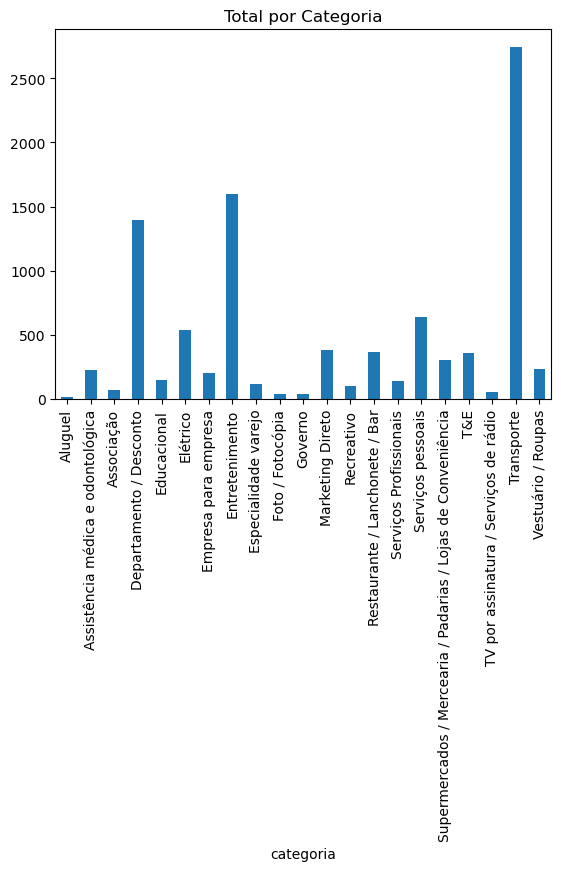

In [45]:
# Utilizando um gráfico de barras para observar o valor gasto por categoria.
total_por_categoria = df_gastos.groupby('categoria')['valor_reais'].sum()
total_por_categoria.plot(kind='bar')
plt.title('Total por Categoria')
plt.show()

In [46]:
# Achei um pouco estranho esse valor do transporte estar tão mais alto em relação as outras categorias, então fiz um filtro
# na coluna de categoria retornando somente 'Transporte' e meu foco é visualizar quais estabelecimentos/produtos estão inclusos.
df_gastos[df_gastos['categoria'] == 'Transporte']['descricao'].unique()

['UBER', 'AUTOPASS S.A(EMTU)', 'TICKETMASTER BRASIL LT']
Categories (55, object): ['ALIPIO ANDRE DOS SANTO', 'AMAZONPRIMEBR', 'AMERICANAS  *SUPRY POY', 'AUTOPASS S.A(EMTU)', ..., 'TICKETMASTER BRASIL LT', 'UBER', 'UDEMY SUBSCRIPTION     +1', 'ZATTINI']

In [47]:
# Como resultado do filtro, deu pra perceber que Uber e Autopass(transporte público) estão categorizados corretamente, porém,
# Ticketmaster foi categorizado incorretamente como transporte na fatura do cartão e isso estava elevando o valor da categoria.
# Realizando um novo filtro, consegui substituir para a categoria correta 'Entretenimento' os valores referentes ao Ticketmaster,
# que são de ingressos que eu comprei para ir em shows nesses últimos meses.
df_gastos.loc[df_gastos['descricao'] == 'TICKETMASTER BRASIL LT', 'categoria'] = 'Entretenimento'

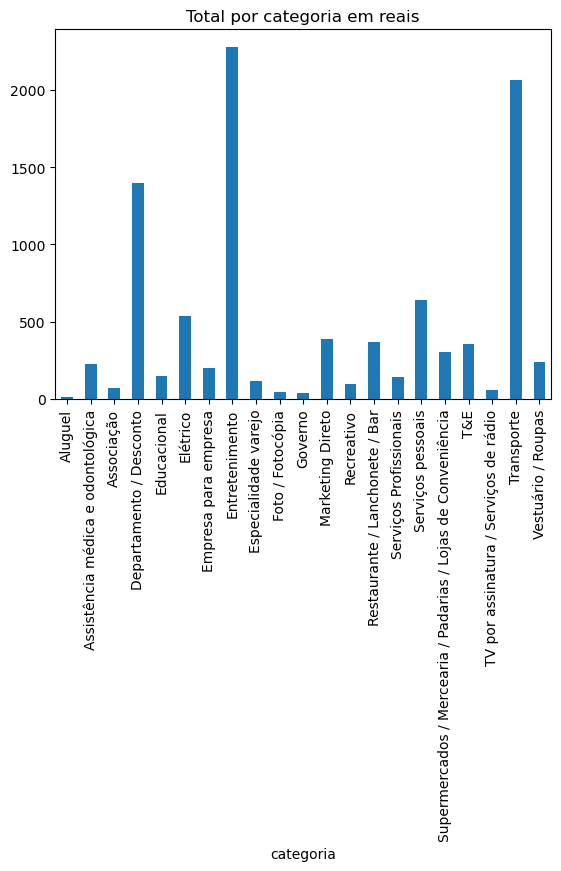

In [48]:
# Agora é possível verificar os valores atualizados no gráfico e estão muito mais condizentes com meu perfil de gasto.
total_por_categoria = df_gastos.groupby('categoria')['valor_reais'].sum()
total_por_categoria.plot(kind='bar')
plt.title('Total por categoria em reais')
plt.show()

In [49]:
# A ideia para o próximo gráfico é organizar os total de gastos por mês, e para isso, separei a data da cobrança em 3 novas
# colunas de dia, mês e ano.
df_gastos['dia_cobranca'] = pd.DatetimeIndex(df_gastos['data_cobranca']).day
df_gastos['mes_cobranca'] = pd.DatetimeIndex(df_gastos['data_cobranca']).month
df_gastos['ano_cobranca'] = pd.DatetimeIndex(df_gastos['data_cobranca']).year

In [50]:
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela,dia_cobranca,mes_cobranca,ano_cobranca
0,2023-05-10,2024-01-10,Serviços pessoais,O BOTICARIO,13.18,Cartão Virtual,9,10,10,1,2024
1,2023-10-01,2024-02-01,Serviços pessoais,O BOTICARIO,20.52,Cartão Virtual,5,7,1,2,2024
2,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4,15,1,2024
3,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2,15,1,2024
4,2023-12-15,2024-01-15,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10,15,1,2024


In [51]:
# Criei uma nova variável com a junção das informações de mês e ano, para conseguir plotar o gráfico em ordem cronológica.
df_gastos['mes_ano'] = df_gastos['data_cobranca'].dt.strftime('%Y-%m')

total_por_mes = df_gastos.groupby('mes_ano')['valor_reais'].sum()
total_por_mes.info()
total_por_mes

<class 'pandas.core.series.Series'>
Index: 7 entries, 2023-08 to 2024-02
Series name: valor_reais
Non-Null Count  Dtype  
--------------  -----  
7 non-null      float64
dtypes: float64(1)
memory usage: 112.0+ bytes


mes_ano
2023-08    1907.04
2023-09    1420.68
2023-10    2040.75
2023-11     926.86
2023-12    1038.37
2024-01    1973.62
2024-02     420.63
Name: valor_reais, dtype: float64

In [52]:
# Esse comando tranforma o campo mes_ano no tipo data.
total_por_mes.index = pd.to_datetime(total_por_mes.index)
total_por_mes.info()
total_por_mes

<class 'pandas.core.series.Series'>
DatetimeIndex: 7 entries, 2023-08-01 to 2024-02-01
Series name: valor_reais
Non-Null Count  Dtype  
--------------  -----  
7 non-null      float64
dtypes: float64(1)
memory usage: 112.0 bytes


mes_ano
2023-08-01    1907.04
2023-09-01    1420.68
2023-10-01    2040.75
2023-11-01     926.86
2023-12-01    1038.37
2024-01-01    1973.62
2024-02-01     420.63
Name: valor_reais, dtype: float64

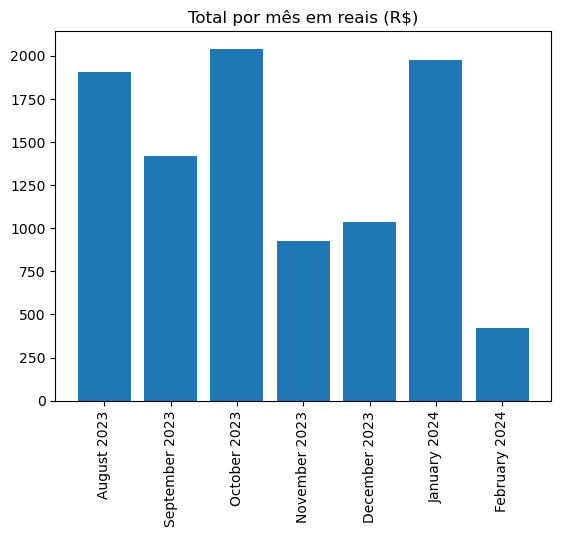

In [53]:
# Plotando o gráfico de gastos por mês.
plt.bar(total_por_mes.index.strftime('%B %Y'), total_por_mes.values)
plt.title('Total por mês em reais (R$)')
plt.xticks(rotation=90)
plt.show()

In [54]:
# Indo além, decidi explorar um outro tipo de visualização que é o heatmap calendar. Nele é possível identificar os dias em que
# meu gasto foi mais alto.
gasto_por_dia = pd.Series(df_gastos['valor_reais'].values, index=df_gastos['data_cobranca'])

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


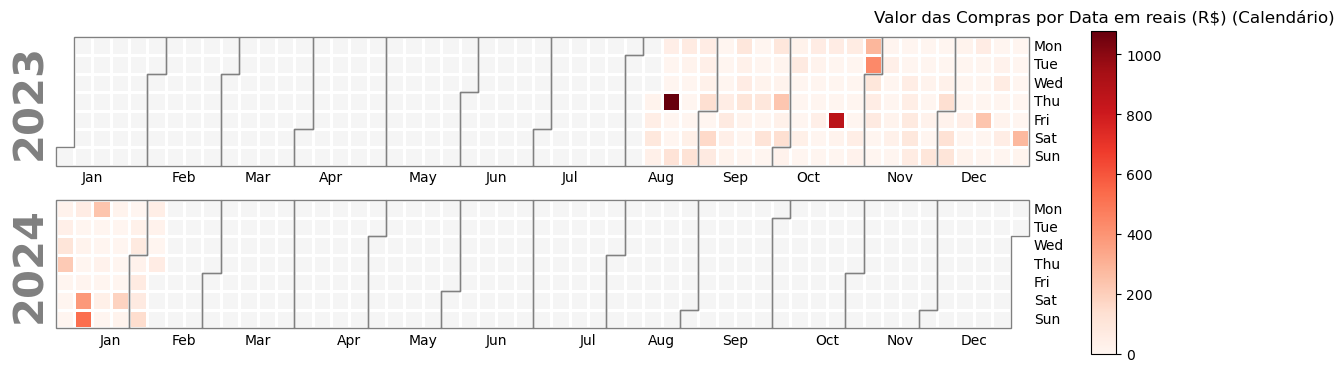

In [55]:
# Essa forma de visualização é bem intuitiva e traz os gastos diários para serem vistos no detalhe.
import calplot
calplot.calplot(gasto_por_dia, cmap='Reds')
plt.title('Valor das Compras por Data em reais (R$) (Calendário)')
plt.show()

In [56]:
# Agora já é possível criar uma nova tabela atualizada no MySQL que será utilizada como base para criação de um dashboard no
# PowerBI.
# Um último head() pra idenficar as colunas e campos que serão utilizados na construção da nova tabela.
df_gastos.head()

,data_compra,data_cobranca,categoria,descricao,valor_reais,tipo_cartao,parcela_atual,total_parcela,dia_cobranca,mes_cobranca,ano_cobranca,mes_ano
0,2023-05-10,2024-01-10,Serviços pessoais,O BOTICARIO,13.18,Cartão Virtual,9,10,10,1,2024,2024-01
1,2023-10-01,2024-02-01,Serviços pessoais,O BOTICARIO,20.52,Cartão Virtual,5,7,1,2,2024,2024-02
2,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,64.97,Cartão Virtual,2,4,15,1,2024,2024-01
3,2023-12-15,2024-01-15,Departamento / Desconto,ZATTINI,83.24,Cartão Virtual,2,2,15,1,2024,2024-01
4,2023-12-15,2024-01-15,Departamento / Desconto,MLP *ZATTINI,87.43,Cartão Virtual,2,10,15,1,2024,2024-01


### Conectando ao banco de dados e construindo a nova tabela.

In [57]:
connection = mysql.connector.connect(
    host=os.getenv('servidor'),
    user=os.getenv('usuario'),
    password=os.getenv('senha'),
    database='projeto-financas'
)
cursor = connection.cursor()

In [58]:
create_table_query = """
CREATE TABLE IF NOT EXISTS gastos_cartao_atualizada (
    id INT AUTO_INCREMENT PRIMARY KEY,
    data_compra DATE,
    data_cobranca DATE,
    categoria VARCHAR(100),
    descricao VARCHAR(100),
    valor_reais FLOAT,
    tipo_cartao VARCHAR(50),
    parcela_atual INT,
    total_parcela INT,
    dia_cobranca INT,
    mes_cobranca INT,
    ano_cobranca INT,
    mes_ano VARCHAR(20)
)
"""
cursor.execute(create_table_query)

In [59]:
for indice, linha in df_gastos.iterrows():
    insert_query = f"""INSERT INTO gastos_cartao_atualizada (data_compra, data_cobranca, categoria, descricao, valor_reais, 
    tipo_cartao, parcela_atual, total_parcela, dia_cobranca, mes_cobranca, ano_cobranca, mes_ano) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    valores = tuple(linha)
    cursor.execute(insert_query, valores)

In [60]:
connection.commit()
connection.close()